In [1]:
import os
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

%matplotlib inline

# Setup data location

In [2]:
train_dir = '/datashare/datasets_3rd_party/bdd/bdd100k/images/100k/train'
label_file = '/datashare/datasets_3rd_party/bdd/bdd100k/labels_new/bdd100k_labels_images_train.json'

resize_image = True
image_ext = '.jpg'
#new_w = 800
#new_h = 288
new_w = 1280
new_h = 720
thickness = 8

# Loading data and select the first image in the label list to visualize

In [3]:
data = json.load(open(label_file))

In [4]:
img_info = data[13]
raw_file = os.path.join(train_dir, img_info['name'])
lane_labels = [l for l in img_info['labels']
               if l['category'] == 'lane' and l['attributes']['laneDirection'] == 'parallel']
print(img_info['name'])

0008a165-c48f4b3e.jpg


# Load the raw image and lane annotations. 

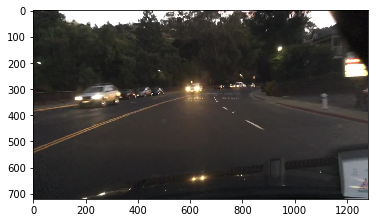

In [5]:
#img = plt.imread(raw_file)
#this will get the same result with plt.imread
lanes = []
img = cv2.imread(raw_file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

w = img.shape[1] # 1640
h = img.shape[0] # 590

x_rate = 1.0 * new_w / w
y_rate = 1.0 * new_h / h

if resize_image:
    img = cv2.resize(img, (new_w, new_h))
    
for l in lane_labels:
    lane = l['poly2d'][0]['vertices']
    lane = sorted(lane, key=lambda x: x[1])
    lanes.append(lane)

if resize_image:
    gt_lanes_org = [[(int(x*x_rate), int(y*y_rate)) for (x, y) in lane] for lane in lanes] 
    
plt.imshow(img)
plt.show()

# Merge consecutive lines into 1 lane

In [12]:
# assuming that double-line is consecutive
method = 'iou' # or, iou

EPS = 1e-6

def iou(img1, img2):
    intersection = (img1 & img2).sum()
    union = (img1 | img2).sum()
    iou = (intersection + EPS) / (union + EPS)
    return iou

if method == 'angle':
    # maximum angle difference threshold to be considered a same line
    method_threshold = 4
    angles = []
    for lane in lanes:
        # take the start point and end point to compute the line angle
        # while this improve the accuracy in case of straing light
        # this is prone to error in case of curve (use first 2 points instead)
        x0 = lane[0][0]
        x1 = lane[1][0]
        y0 = lane[0][1]
        y1 = lane[1][1]
        # use abs here because we only care about the angle, not the orientation 
        angle = np.rad2deg(np.arctan2(abs(y1 - y0), abs(x1 - x0)))
        angles.append(angle)

    # difference between two consecutive angles in this list
    diffs = [abs(j-i) for i, j in zip(angles[:-1], angles[1:])]

elif method == 'iou':
    # maximum angle difference threshold to be considered a same line
    method_threshold = -0.2
    
    imgs = []
    for lane in lanes:
        # fill the lines so that IoU can be computed!
        tmp_img = np.zeros(shape=[h, w], dtype=np.uint8)
        cv2.polylines(tmp_img, np.int32([lane]), isClosed=False, color=1, thickness=20)
        imgs.append(np.int32(tmp_img))

    # IoU difference between two consecutive (masked) images 
    diffs = [-iou(imgs[i], imgs[i+1]) for i, img in enumerate(imgs[:-1])]

print(diffs)
merge_lanes = []
line_merged = False
# merge lanes based on angle differences
for i,diff in enumerate(diffs):
    if line_merged:
        line_merged = False
        continue
    this_lane = lanes[i]
    if diff < method_threshold:
        # next line will be merged
        this_lane.extend(lanes[i+1])
        line_merged = True    
    
    this_lane = sorted(this_lane, key=lambda x: x[1])
    merge_lanes.append(this_lane)
    if i == len(diffs)-1 and not line_merged:
        this_lane = sorted(lanes[i+1], key=lambda x: x[1])
        merge_lanes.append(this_lane)

if resize_image:
    gt_lanes_merged = [[(int(x*x_rate), int(y*y_rate)) for (x, y) in lane] for lane in merge_lanes]

[-0.29154700964366975, -3.9969623084856725e-11, -0.42086668112907444, -4.716091303305221e-11, -4.025764895168045e-11, -5.6941122875700876e-11]


# Draw the ground-truth points

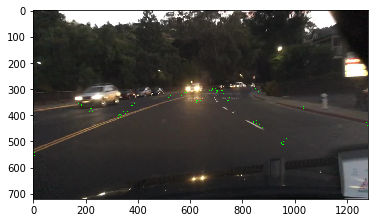

In [13]:
img_vis = img.copy()

for lane in gt_lanes_org:
    for pt in lane:
        cv2.circle(img_vis, pt, radius=thickness, color=(0, 255, 0))

plt.imshow(img_vis)
plt.show()

# Fit the ground truth points with a lines

/home/sang/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


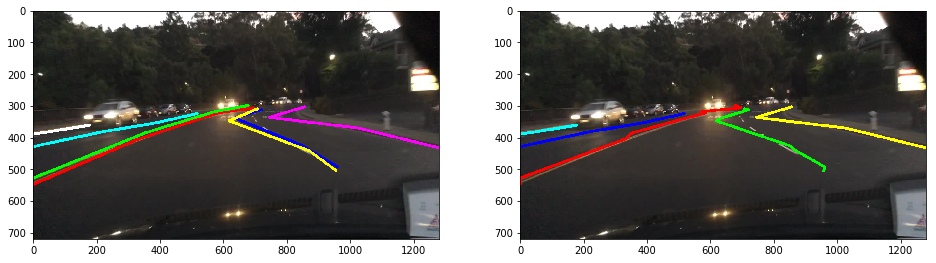

In [14]:
colors = [(255,0,0),(0,255,0),(0,0,255),
         (255,255,0),(0,255,255),(255,0,255),
         (255,255,255),(0,0,0),
         (127,0,0),(0,127,0),(0,0,127),
         (127,127,0),(0,127,127),(127,0,127),
         (127,127,127),(0,0,0)]

fig=plt.figure(figsize=(16, 16))
columns = 2
rows = 1

# Visualize orginal annotations
img_vis = img.copy()    
for i,lane in enumerate(gt_lanes_org):
    fig.add_subplot(rows, columns, 1)
    cv2.polylines(img_vis, np.int32([lane]), isClosed=False, color=colors[i], thickness=thickness)
    plt.imshow(img_vis)

# Visualize merged annotations (lines belong to a same lane are connected)
img_vis = img.copy()
for i,lane in enumerate(gt_lanes_merged):
    fig.add_subplot(rows, columns, 2)
    cv2.polylines(img_vis, np.int32([lane]), isClosed=False, color=colors[i], thickness=thickness)
    plt.imshow(img_vis)
    
plt.show()

# Generate binary image

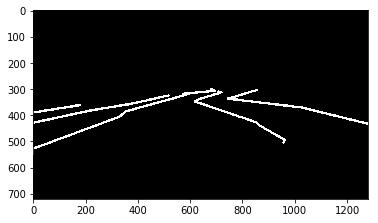

In [15]:
bin_img = np.zeros(shape=[img.shape[0], img.shape[1]], dtype=np.uint8)
nlanes = len(gt_lanes_merged)
for i, lane in enumerate(gt_lanes_merged):
    cv2.polylines(bin_img, np.int32([lane]), isClosed=False, color=1, thickness=thickness)
plt.imshow(bin_img, cmap=plt.cm.gray)
plt.show()    

# Generate lane instance image (different colors for different lanes)

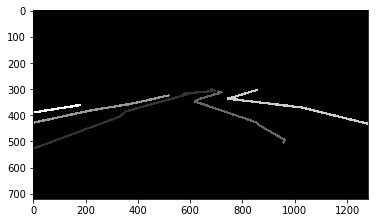

In [16]:
bin_img = np.zeros(shape=[img.shape[0], img.shape[1]], dtype=np.uint8)
nlanes = len(gt_lanes_merged)
color_codes = list(range(0, 255, 255//(nlanes + 1)))[1:]
for i, lane in enumerate(gt_lanes_merged):
    cv2.polylines(bin_img, np.int32([lane]), isClosed=False, color=color_codes[i], thickness=thickness)
plt.imshow(bin_img, cmap=plt.cm.gray)
plt.show()    

In [17]:
print(w, h)

1280 720
